# Mecklin polyp risk
Transform Mecklin polyp risk data to usable endpoints for analysis. Data originally extracted using PlotDigitizer online app. Data for Lynch Syndrome patients, broken down by male and female. Not gene-specific.

In [89]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from csaps import csaps

PARENT_DIR = "/Users/sophiewagner/repos/lynch-syndrome"
DATA_DIR = os.path.join(PARENT_DIR, "data")

In [93]:
# Load data
file_path = os.path.join(DATA_DIR, "polyps.xlsx")
mecklin = pd.read_excel(file_path, sheet_name="mecklin_2007_km")

In [94]:
# Extract data from sheet
data = mecklin.iloc[2:139,1:-2].reset_index(drop=True)
data.columns = ['sex', 'val_type', 'age','val']
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['val'] = pd.to_numeric(data['val'], errors='coerce')
data.head()

,sex,val_type,age,val
0,female,lower,24.755583,0.007065
1,female,lower,39.158271,0.003265
2,female,lower,41.389655,0.037643
3,female,lower,42.337443,0.063084
4,female,lower,44.925582,0.076740


In [106]:
def extract_csaps(data, sex, val_type, smooth=0.1):
    d = data.loc[
        (data['sex']==sex) & 
        (data['val_type']==val_type)
        ]
    dummy = pd.DataFrame({'age':75, 'val':d['val'].max()*0.95}, index=[0]) # add dummy point
    d = pd.concat([d, dummy], ignore_index=True)
    d = d.sort_values('age').reset_index(drop=True)
    spline = csaps(d['age'], d['val'], smooth=smooth)
    x = np.arange(20, 75, 1)
    y = spline(x).clip(0,1)
    y = np.maximum.accumulate(y)
    return y

In [107]:
ages = np.arange(20, 75, 1)
df = pd.DataFrame({
    'sex': ['female'] * len(ages) + ['male'] * len(ages),
    'age': np.tile(ages, 2)  # repeat age array for each sex
})

# Extract values for each sex and concatenate
df_female = pd.DataFrame({
    'value': extract_csaps(data, 'female', 'value', smooth=0.01),
    'lower': extract_csaps(data, 'female', 'lower', smooth=0.01),
    'upper': extract_csaps(data, 'female', 'upper', smooth=0.01)
}, index=range(len(ages)))

df_female['value'] = np.maximum(df_female['lower'], df_female['value'])
df_female['upper'] = np.maximum(df_female['value'], df_female['upper'])

df_male = pd.DataFrame({
    'value': extract_csaps(data, 'male', 'value', smooth=0.01),
    'lower': extract_csaps(data, 'male', 'lower', smooth=0.01),
    'upper': extract_csaps(data, 'male', 'upper', smooth=0.01)
},index=range(len(ages)))
df_male['value'] = np.maximum(df_male['lower'], df_male['value'])
df_male['upper'] = np.maximum(df_male['value'], df_male['upper'])
# Combine extracted values back into df
df[['value', 'lower', 'upper']] = pd.concat([df_female, df_male], ignore_index=True)


In [108]:
df.head()

,sex,age,value,lower,upper
0,female,20,0.014734,0.00403,0.014734
1,female,21,0.027348,0.00403,0.035379
2,female,22,0.039812,0.00403,0.060028
3,female,23,0.051979,0.00403,0.084461
4,female,24,0.063699,0.00403,0.108573


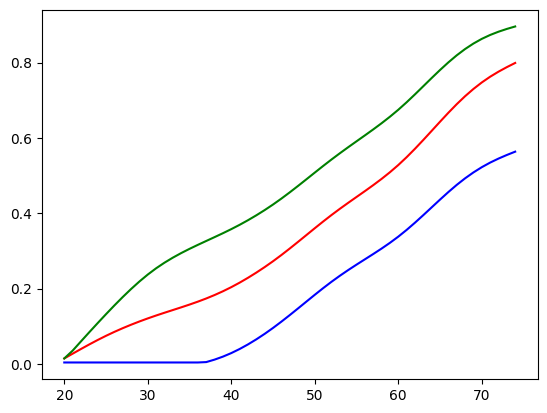

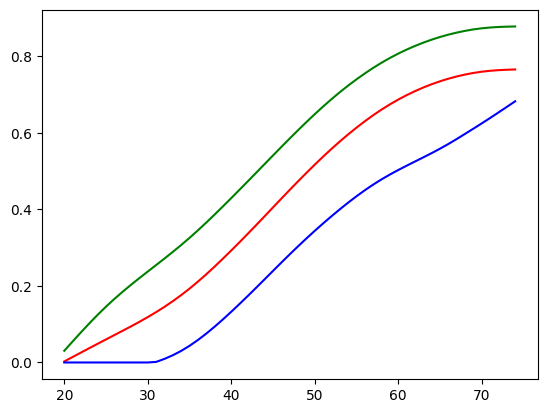

In [109]:
plt.plot(ages, df_female['value'], color='red')
plt.plot(ages, df_female['lower'], color='blue')
plt.plot(ages, df_female['upper'], color='green')
plt.show()

plt.plot(ages, df_male['value'], color='red')
plt.plot(ages, df_male['lower'], color='blue')
plt.plot(ages, df_male['upper'], color='green')
plt.show()

In [114]:
from scipy.optimize import curve_fit
df['se'] = (df['upper'] - df['lower']) / (1.96*2)
def plot_logistic(data, sex):
    def logistic(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    d = df.loc[df['sex']==sex]
    p0 = [d['value'].max(), 0.1, 50]
    sigma= d['se'].values
    
    init_fit = logistic(ages, *p0)
    params, _ = curve_fit(logistic, ages, d['value'], p0=p0, sigma=sigma, absolute_sigma=True)
    risk_fit = logistic(ages, *params)
    
    plt.plot(ages, d['value'], 'o', label=f'{sex} risk')
    plt.plot(ages, init_fit, 'r--', label='Initial fit')
    plt.plot(ages, risk_fit, 'g-', label='Fitted logistic curve')
    plt.xlabel("Age")
    plt.ylabel("Cumulative polyp Risk")
    plt.title(f"Smooth Fit of polyp Cumulative Risk ({sex})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return risk_fit

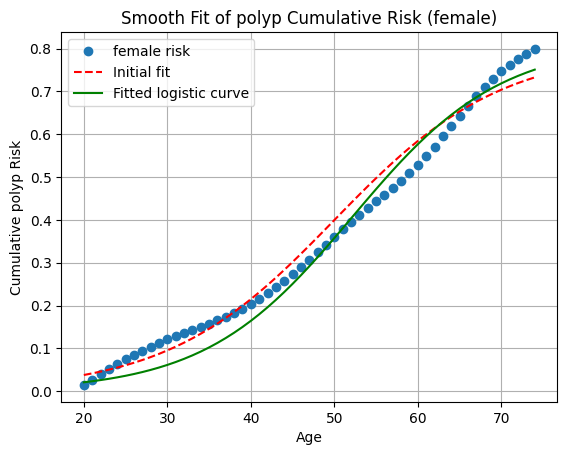

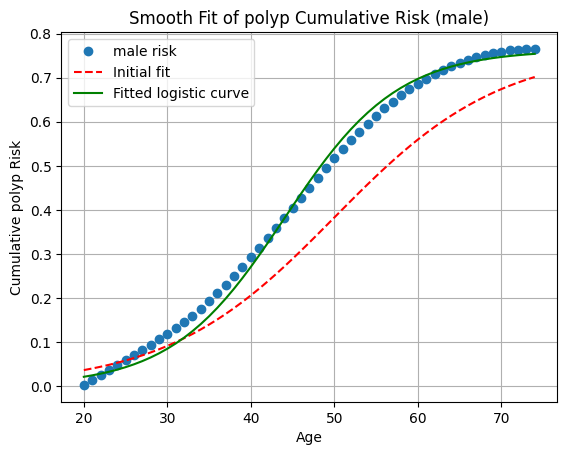

In [116]:
polyp_risk_fit = {}
polyp_risk_fit['ages'] = ages
polyp_risk_fit['female'] = plot_logistic(df, 'female')
polyp_risk_fit['male'] = plot_logistic(df, 'male')

In [118]:
print(polyp_risk_fit['female'][-1])
print(polyp_risk_fit['male'][-1])

0.7508126716588613
0.7542192180583569


In [117]:
pd.DataFrame(polyp_risk_fit).to_csv(os.path.join(DATA_DIR, "mecklin_polyp_risk.csv"), index=False)

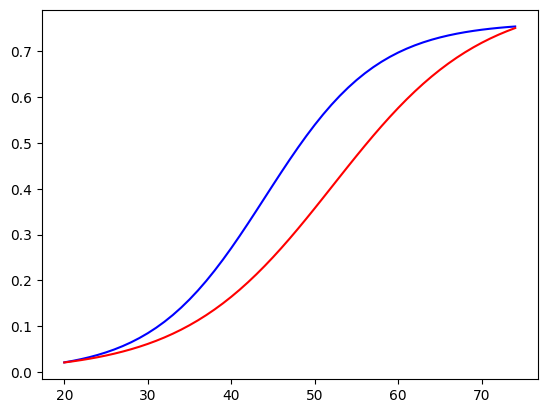

In [119]:
plt.plot(ages, polyp_risk_fit['male'], color='blue')
plt.plot(ages, polyp_risk_fit['female'], color='red')